In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print('----------- Float tensor set --------------')
else:
    print('---------------------- No CUDA -----------------')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = "BAAI/bge-large-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


----------- Float tensor set --------------


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
print(model.embeddings(input_ids=torch.tensor([[ 101, 3894, 2003, 2613,  102]]), token_type_ids = torch.tensor([[0, 0, 0, 0, 0]])))

tensor([[[-0.0579, -0.1454, -0.1149,  ..., -0.0850, -0.0970,  0.0441],
         [-1.0723, -0.3718,  1.0997,  ..., -1.1722,  0.3788,  0.6327],
         [ 0.2190,  0.1230, -0.4146,  ...,  0.5126, -0.3004,  0.8545],
         [-0.2538,  0.9347,  0.9419,  ...,  0.3180,  1.0190,  0.1344],
         [-0.0852,  0.1868, -0.1751,  ...,  0.0075,  0.3693,  0.0385]]],
       grad_fn=<NativeLayerNormBackward0>)


In [ ]:
# from tqdm import tqdm

# for i in tqdm(range(20_000)):
#     for j in range(20_000):
#         if i == j: continue
#         model.embeddings(input_ids=torch.tensor([[ 101, i, j, 1,  102]]), token_type_ids = torch.tensor([[0, 0, 0, 0, 0]]))

import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# Pre-create the fixed tensor components to avoid repetition
token_type_ids = torch.tensor([[0, 0, 0, 0, 0]]).to('cuda')

# Function to generate input batches
def generate_input_batches(batch_size=64, vocab_size=20_000):
    input_ids = []
    for i in range(vocab_size):
        for j in range(vocab_size):  # Skip j <= i to avoid checking i == j
            input_ids.append([101, i, j, 1, 102])

        # Yield the batch when it's filled to avoid storing everything at once
        if len(input_ids) >= batch_size:
            yield torch.tensor(input_ids).to('cuda')
            input_ids = []  # Reset the batch

    # Yield any remaining input_ids that didn't fill a full batch
    if input_ids:
        yield torch.tensor(input_ids)

# Set up the DataLoader to process input batches
batch_size = 100_000  # Modify this based on available memory
input_batches = generate_input_batches(batch_size=batch_size)

# Now iterate over the batches and feed them to the model
for input_batch in tqdm(input_batches, desc="Processing batches"):
    # Assuming the model can handle batch processing
    input_batch = input_batch.unsqueeze(1)  # Add batch dimension
    model.embeddings(input_ids=input_batch, token_type_ids=token_type_ids)



Processing batches: 4000it [19:42,  3.38it/s]


In [ ]:
targetText = 'magic is real'
print(tokenizer(targetText, return_tensors='pt'))
outputs = model(**tokenizer(targetText, return_tensors='pt'), output_hidden_states=True)
target_embedding = outputs.pooler_output[0]
print(target_embedding)

{'input_ids': tensor([[ 101, 3894, 2003, 2613,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
tensor([-0.9450, -0.8097, -0.8362,  ...,  0.4859,  0.9817, -0.8716],
       grad_fn=<SelectBackward0>)


In [ ]:
tokenizer(targetText, return_tensors='pt')

{'input_ids': tensor([[ 101, 3894, 2003, 2613,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [ ]:
outputs.pooler_output[0].shape

torch.Size([1, 1024])

In [ ]:
for i in range(len(outputs.hidden_states)):
    print(outputs.hidden_states[i])

In [ ]:
outputs.pooler_output[0]

tensor([-0.9450, -0.8097, -0.8362,  ...,  0.4859,  0.9817, -0.8716],
       grad_fn=<SelectBackward0>)

In [ ]:
model.pooler(outputs.hidden_states[-1])[0]

tensor([-0.9450, -0.8097, -0.8362,  ...,  0.4859,  0.9817, -0.8716],
       grad_fn=<SelectBackward0>)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch.nn.functional as F

def cosine_similarity(embedding1, embedding2):
  # Normalize the embeddings
  embedding1_normalized = F.normalize(embedding1, p=2, dim=0)
  embedding2_normalized = F.normalize(embedding2, p=2, dim=0)

  # Calculate the dot product
  dot_product = torch.dot(embedding1_normalized, embedding2_normalized)

  return dot_product.item()

text1 = 'magic is real'
text2 = 'magic are real'
print(tokenizer(text1, return_tensors='pt'))
print(tokenizer(text2, return_tensors='pt'))
cosine_similarity(model(**tokenizer(text1, return_tensors='pt'), output_hidden_states=True).pooler_output[0], model(**tokenizer(text2, return_tensors='pt'), output_hidden_states=True).pooler_output[0])

{'input_ids': tensor([[ 101, 3894, 2003, 2613,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
{'input_ids': tensor([[ 101, 3894, 2024, 2613,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}


0.9960455894470215

In [ ]:
cosineSimilarities = []

for i in range(len(outputs.hidden_states)):
    hiddenStateSimilarity = []
    embeddingI = model.pooler(outputs.hidden_states[i])[0]
    for j in range(len(outputs.hidden_states)):
        embeddingJ = model.pooler(outputs.hidden_states[j])[0]
        hiddenStateSimilarity.append(round(cosine_similarity(embeddingI, embeddingJ), 2))
    cosineSimilarities.append(hiddenStateSimilarity)

In [ ]:
for i in range(len(cosineSimilarities)):
    print(f'{cosineSimilarities[i]}')

[1.0, 0.85, 0.84, 0.84, 0.85, 0.78, 0.59, 0.35, -0.0, -0.06, 0.01, 0.17, -0.01, 0.07, -0.08, 0.08, 0.1, -0.15, -0.17, -0.03, -0.01, 0.1, 0.11, 0.19, 0.16]
[0.85, 1.0, 1.0, 0.99, 0.99, 0.93, 0.7, 0.36, -0.05, -0.09, 0.05, 0.29, 0.07, 0.18, -0.01, 0.24, 0.26, -0.12, -0.2, -0.01, 0.01, 0.16, 0.17, 0.26, 0.27]
[0.84, 1.0, 1.0, 1.0, 0.99, 0.93, 0.71, 0.36, -0.07, -0.11, 0.04, 0.29, 0.06, 0.18, -0.01, 0.26, 0.29, -0.1, -0.19, 0.01, 0.04, 0.19, 0.2, 0.29, 0.3]
[0.84, 0.99, 1.0, 1.0, 1.0, 0.93, 0.7, 0.35, -0.08, -0.11, 0.03, 0.28, 0.05, 0.15, -0.03, 0.25, 0.28, -0.1, -0.18, 0.02, 0.04, 0.2, 0.21, 0.3, 0.3]
[0.85, 0.99, 0.99, 1.0, 1.0, 0.95, 0.74, 0.38, -0.09, -0.13, 0.02, 0.28, 0.05, 0.15, -0.04, 0.26, 0.29, -0.09, -0.18, 0.04, 0.06, 0.22, 0.23, 0.33, 0.33]
[0.78, 0.93, 0.93, 0.93, 0.95, 1.0, 0.91, 0.58, -0.04, -0.1, 0.08, 0.39, 0.12, 0.2, -0.02, 0.32, 0.37, -0.08, -0.19, 0.08, 0.1, 0.31, 0.31, 0.42, 0.45]
[0.59, 0.7, 0.71, 0.7, 0.74, 0.91, 1.0, 0.79, 0.07, -0.0, 0.18, 0.49, 0.21, 0.25, 0.01, 

In [ ]:
import numpy as np

def find_all_possible_inputs(y, W, b):
    """
    Find all possible inputs x that satisfy y = tanh(Wx + b)

    Parameters:
    y: target output vector (must have all elements between -1 and 1)
    W: weight matrix
    b: bias vector

    Returns:
    function that generates solutions based on input z
    """
    # Check if y is valid (all elements between -1 and 1)
    if not np.all(np.abs(y) < 1):
        raise ValueError("All elements of y must be between -1 and 1")

    # Step 1: Apply arctanh
    arctanh_y = np.arctanh(y)

    # Step 2: Subtract bias
    target = arctanh_y - b

    # Step 3: Find pseudoinverse of W
    W_pinv = np.linalg.pinv(W)

    # Create nullspace projection matrix
    I = np.eye(W.shape[1])
    nullspace_proj = I - W_pinv @ W

    # Return function that generates solutions for any z
    def solution_generator(z):
        particular_solution = W_pinv @ target
        nullspace_component = nullspace_proj @ z
        print("Nullspace component magnitude:", np.linalg.norm(nullspace_proj @ z))
        print("Particular solution magnitude:", np.linalg.norm(particular_solution))
        return particular_solution + nullspace_component

    return solution_generator

# Create sample data
n = 1024  # Using small dimension for example
W = model.pooler.dense.weight.cpu().detach().clone().numpy()
b = model.pooler.dense.bias.cpu().detach().clone().numpy()
x_original = outputs.hidden_states[24][0][0].cpu().clone().detach().numpy()
y = outputs.pooler_output[0].cpu().clone().detach().numpy()

# Find solution generator
solution_gen = find_all_possible_inputs(y, W, b)

# Generate some solutions
z = np.random.randn(n)
x_solution = solution_gen(z)

# Verify solution
y_reconstructed = np.tanh(W @ x_solution + b)
print("Original y:", y)
print("Reconstructed y:", y_reconstructed)
print("Original x:", x_original)
print("Reconstructed x:", x_solution)
print("Difference in input:", cosine_similarity(torch.tensor(outputs.hidden_states[24][0][0].clone().detach(), dtype=torch.float32),
                                                torch.tensor(x_solution, dtype=torch.float32)))
print("Difference in output:", cosine_similarity(torch.tensor(y, dtype=torch.float32), torch.tensor(y_reconstructed, dtype=torch.float32)))

Nullspace component magnitude: 0.0013127521677299607
Particular solution magnitude: 16.7591
Original y: [-0.94499    -0.8097365  -0.83618635 ...  0.48591825  0.9817478
 -0.8716495 ]
Reconstructed y: [-0.94498924 -0.80972441 -0.83615186 ...  0.48591111  0.98174978
 -0.87165019]
Original x: [ 0.35757935  0.3042189   0.56853807 ... -0.26189774  0.37367082
  0.65639853]
Reconstructed x: [ 0.35779906  0.30413393  0.56839237 ... -0.26174653  0.37360273
  0.65654937]
Difference in input: 0.9999998807907104
Difference in output: 1.0


<ipython-input-35-7715d554ad09>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Difference in input:", cosine_similarity(torch.tensor(outputs.hidden_states[24][0][0].clone().detach(), dtype=torch.float32),


In [ ]:
import numpy as np

def find_possible_encoder_inputs(output, layer_params, prev_layer_output=None):
    """
    Find possible inputs that could have produced the given output through a BERT encoder layer

    Parameters:
    output: target output tensor from the layer
    layer_params: dict containing weight matrices and biases:
        - attention_qkv: weights for query, key, value projections
        - attention_output: weights for attention output projection
        - intermediate: weights for intermediate dense layer
        - output: weights for output dense layer
        - layernorm1: first LayerNorm parameters
        - layernorm2: second LayerNorm parameters
    prev_layer_output: optional output from previous layer (for attention computation)

    Returns:
    function that generates possible input solutions
    """
    def reverse_layer_norm(normalized_output, gamma, beta, epsilon=1e-12):
        # Approximate inverse of layer normalization
        mean = beta[None, :]  # Shape: [1, 1024] to broadcast with [5, 1024]
        var = (gamma[None, :] ** 2) - epsilon
        return normalized_output * np.sqrt(var) + mean

    def reverse_gelu(y):
        # Simpler, more stable GELU inverse approximation
        # Add small epsilon to prevent division by zero
        eps = 1e-6

        def gelu_forward(x):
            return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))

        def newton_step(x):
            gelu = gelu_forward(x)
            # Clip to prevent division by zero
            x_safe = np.clip(x, -100, 100)
            grad = 0.5 * (1 + np.tanh(np.sqrt(2/np.pi) * (x_safe + 0.044715 * x_safe**3)))
            grad = np.clip(grad, eps, 1.0)  # Ensure gradient is never zero
            return x - (gelu - y) / grad

        x = y  # Initial guess
        for _ in range(3):  # Fewer iterations for stability
            x = np.clip(newton_step(x), -100, 100)  # Clip values to prevent overflow
        return x

    def find_attention_inputs(target_attention_output, qkv_weights, output_weights, num_heads=16):
        W_o = output_weights['weight']
        b_o = output_weights['bias']
        W_o_pinv = np.linalg.pinv(W_o)

        # Get dimensions
        seq_length = target_attention_output.shape[0]
        hidden_size = target_attention_output.shape[1]
        head_size = hidden_size // num_heads

        def attention_solution_generator(z):
            # Instead of trying to invert the full attention mechanism,
            # let's just try to find a vector that produces the right output
            target = target_attention_output - b_o[None, :]  # Remove bias

            # Use pseudo-inverse to find a particular solution
            particular = (W_o_pinv @ target.T).T

            # Add a small perturbation from the null space
            nullspace = np.eye(W_o.shape[1]) - W_o_pinv @ W_o
            z_scaled = z * 0.1  # Scale down the random component
            solution = particular + (nullspace @ z_scaled.T).T

            return solution

        return attention_solution_generator

    def solution_generator(z_attention, z_intermediate, temperature=1.0):
        # Reverse the transformations in reverse order

        # 1. Reverse the final layer norm
        prenorm2 = reverse_layer_norm(
            output,
            layer_params['layernorm2']['gamma'],
            layer_params['layernorm2']['beta']
        )

        # 2. Reverse the residual connection from the intermediate layer
        intermediate_output = prenorm2 - output  # Remove residual

        # 3. Reverse the output dense layer
        W_out = layer_params['output']['weight']
        b_out = layer_params['output']['bias']
        intermediate_hidden = np.linalg.pinv(W_out) @ intermediate_output.T  # NOT USING BIAS?
        intermediate_hidden = intermediate_hidden.T  # Back to [5, 4096]

        # 4. Approximate inverse of GELU
        pre_gelu = reverse_gelu(intermediate_hidden)

        # 5. Reverse the intermediate dense layer
        W_int = layer_params['intermediate']['weight']
        b_int = layer_params['intermediate']['bias']
        pre_gelu = pre_gelu.T  # Shape becomes (4096, 5)
        b_int = b_int[:, None]  # Shape becomes (4096, 1)
        attention_output = (np.linalg.pinv(W_int) @ (pre_gelu - b_int)).T  # Back to (5, 1024)

        # 6. Reverse the first layer norm
        prenorm1 = reverse_layer_norm(
            attention_output,
            layer_params['layernorm1']['gamma'],
            layer_params['layernorm1']['beta']
        )

        # 7. Generate possible attention solutions
        attention_gen = find_attention_inputs(
            prenorm1,
            layer_params['attention_qkv'],
            layer_params['attention_output']
        )

        # Combine all solutions
        attention_solution = attention_gen(z_attention)

        return attention_solution

    return solution_generator

In [ ]:
import numpy as np
import torch

def extract_layer_params(bert_layer):
    """Extract parameters from a BertLayer module"""
    params = {}

    # Get attention parameters
    attention = bert_layer.attention.self
    params['attention_qkv'] = {
        'query': attention.query.weight.detach().cpu().numpy(),
        'query_bias': attention.query.bias.detach().cpu().numpy(),
        'key': attention.key.weight.detach().cpu().numpy(),
        'key_bias': attention.key.bias.detach().cpu().numpy(),
        'value': attention.value.weight.detach().cpu().numpy(),
        'value_bias': attention.value.bias.detach().cpu().numpy(),
    }

    # Attention output projection
    params['attention_output'] = {
        'weight': bert_layer.attention.output.dense.weight.detach().cpu().numpy(),
        'bias': bert_layer.attention.output.dense.bias.detach().cpu().numpy()
    }

    # First LayerNorm
    params['layernorm1'] = {
        'gamma': bert_layer.attention.output.LayerNorm.weight.detach().cpu().numpy(),
        'beta': bert_layer.attention.output.LayerNorm.bias.detach().cpu().numpy()
    }

    # Intermediate layer
    params['intermediate'] = {
        'weight': bert_layer.intermediate.dense.weight.detach().cpu().numpy(),
        'bias': bert_layer.intermediate.dense.bias.detach().cpu().numpy()
    }

    # Output layer
    params['output'] = {
        'weight': bert_layer.output.dense.weight.detach().cpu().numpy(),
        'bias': bert_layer.output.dense.bias.detach().cpu().numpy()
    }

    # Second LayerNorm
    params['layernorm2'] = {
        'gamma': bert_layer.output.LayerNorm.weight.detach().cpu().numpy(),
        'beta': bert_layer.output.LayerNorm.bias.detach().cpu().numpy()
    }

    return params

def improve_attention_handling(qkv_weights, attention_output, seq_length=512, num_heads=16):
    """More detailed attention mechanism inversion"""
    head_size = qkv_weights['query'].shape[0] // num_heads

    def attention_solution_generator(z_q, z_k, z_v, temperature=1.0):
        # Split z vectors for each head
        z_q = z_q.reshape(num_heads, seq_length, head_size)
        z_k = z_k.reshape(num_heads, seq_length, head_size)
        z_v = z_v.reshape(num_heads, seq_length, head_size)

        # Generate possible Q, K, V matrices
        Q = np.linalg.pinv(qkv_weights['query']) @ z_q.reshape(-1, head_size * num_heads)
        K = np.linalg.pinv(qkv_weights['key']) @ z_k.reshape(-1, head_size * num_heads)
        V = np.linalg.pinv(qkv_weights['value']) @ z_v.reshape(-1, head_size * num_heads)

        # Reshape to match original dimensions
        Q = Q.reshape(seq_length, num_heads, head_size)
        K = K.reshape(seq_length, num_heads, head_size)
        V = V.reshape(seq_length, num_heads, head_size)

        # Scale factor for attention
        scale = np.sqrt(head_size)

        # Compute attention scores (approximation)
        attention_scores = np.matmul(Q, K.transpose(-2, -1)) / scale
        attention_probs = np.exp(attention_scores * temperature) / np.sum(np.exp(attention_scores * temperature), axis=-1, keepdims=True)

        # Compute attention output
        attention_output = np.matmul(attention_probs, V)

        return attention_output.reshape(seq_length, -1)

    return attention_solution_generator

# Example usage:
def invert_bert_layer(model, layer_idx, output_tensor):
    """Invert a specific BERT layer"""
    # Extract parameters
    layer = model.encoder.layer[layer_idx]
    params = extract_layer_params(layer)

    # Create solution generator
    solution_gen = find_possible_encoder_inputs(
        output_tensor.detach().cpu().numpy(),
        params
    )

    # Generate random z vectors for attention components
    seq_length = output_tensor.shape[0]
    hidden_size = output_tensor.shape[1]
    num_heads = 16  # Assuming 16 attention heads

    z_attention = np.random.randn(seq_length, hidden_size)
    z_intermediate = np.random.randn(seq_length, hidden_size * 4)  # 4x for intermediate size

    # Get possible input
    possible_input = solution_gen(z_attention, z_intermediate)

    # Add inside invert_bert_layer
    attention_output = layer.attention(torch.tensor(possible_input, dtype=torch.float32).unsqueeze(0))[0]
    print(f"Attention similarity: {torch.nn.functional.cosine_similarity(attention_output.flatten(), layer_output[0].flatten(), dim=0).item()}")

    # Get intermediate size correctly
    intermediate_output = layer.intermediate(attention_output)
    intermediate_layer_output = layer.intermediate(layer_output[0].unsqueeze(0))
    print(f"Intermediate similarity: {torch.nn.functional.cosine_similarity(intermediate_output.flatten(), intermediate_layer_output.flatten(), dim=0).item()}")

    return torch.tensor(possible_input, dtype=output_tensor.dtype, device=output_tensor.device)

layer_output = outputs.hidden_states[24]
possible_input = invert_bert_layer(model, 23, layer_output[0])

layer = model.encoder.layer[23]
reconstructed_output = layer(possible_input.unsqueeze(0))[0]

# Check similarity
similarity = torch.nn.functional.cosine_similarity(
    layer_output[0].flatten(),
    reconstructed_output.flatten(),
    dim=0
)
print(f"Reconstruction similarity: {similarity.item()}")

Attention similarity: 0.10488615930080414
Intermediate similarity: 0.03049367666244507
Reconstruction similarity: 0.04939057677984238


In [ ]:
outputs.hidden_states[24][0]

tensor([[ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
        [ 0.3397, -0.2081,  0.5046,  ..., -0.1825,  0.4268,  0.7270],
        [ 0.6616,  0.0069,  0.7108,  ..., -0.3792,  0.4171,  0.5104],
        [ 0.7522,  0.0126,  0.8135,  ..., -0.2740,  0.7368,  0.6462],
        [ 0.6640,  0.0345,  0.8832,  ..., -0.0384,  0.6693,  0.5532]],
       grad_fn=<SelectBackward0>)

In [ ]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [ ]:
print(model.encoder.layer[23].output.dense.weight.shape)

torch.Size([1024, 4096])


In [ ]:
def generate_possible_inputs(normalized_values, weight, bias, input_scale, input_shift):
    # First undo LayerNorm's learned transformations
    unlearned = [(x - bias[idx]) / weight[idx] for idx,x in enumerate(normalized_values)]
    # Now apply our input parameters to generate a possible input sequence
    # Any sequence generated this way would normalize to our target output
    return [x * input_scale + input_shift for x in unlearned]

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

layerNormInput = []
layerNormOutput = []
def hook_function(module, input, output):
    global layerNormInput, layerNormOutput
    # Access input and output tensors of the LayerNorm module
    print("LayerNorm Input:", input[0]) # Accessing the input tensor
    layerNormInput = input[0]
    print("LayerNorm Output:", output) # Accessing the output tensor
    layerNormOutput = output
    # Perform desired operations on input and output

# Register the hook
for hook in model.encoder.layer[23].output.LayerNorm._forward_hooks.copy():
    model.encoder.layer[23].output.LayerNorm._forward_hooks.pop(hook)
hook = model.encoder.layer[23].output.LayerNorm.register_forward_hook(hook_function)

In [ ]:
print(model.encoder.layer[23](outputs.hidden_states[23])[0][0][0])
print(outputs.hidden_states[24][0][0])

LayerNorm Input: tensor([[[ 0.5554,  0.4269,  0.9111,  ..., -0.3931,  0.7964,  1.2763],
         [ 0.5362, -0.4190,  0.8229,  ..., -0.2630,  0.9067,  1.4299],
         [ 1.0879, -0.0599,  1.1569,  ..., -0.6003,  0.8776,  1.0313],
         [ 1.2613, -0.0517,  1.3459,  ..., -0.4244,  1.4467,  1.2856],
         [ 0.9892, -0.0169,  1.3106,  ..., -0.0136,  1.1891,  1.0023]]],
       grad_fn=<AddBackward0>)
LayerNorm Output: tensor([[[ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
         [ 0.3397, -0.2081,  0.5046,  ..., -0.1825,  0.4268,  0.7270],
         [ 0.6616,  0.0069,  0.7108,  ..., -0.3792,  0.4171,  0.5104],
         [ 0.7522,  0.0126,  0.8135,  ..., -0.2740,  0.7368,  0.6462],
         [ 0.6640,  0.0345,  0.8832,  ..., -0.0384,  0.6693,  0.5532]]],
       grad_fn=<NativeLayerNormBackward0>)
tensor([ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
       grad_fn=<SelectBackward0>)
tensor([ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
     

In [ ]:
hook.remove()

In [ ]:
print(layerNormInput[0])
print(layerNormOutput[0])

tensor([[ 0.5554,  0.4269,  0.9111,  ..., -0.3931,  0.7964,  1.2763],
        [ 0.5362, -0.4190,  0.8229,  ..., -0.2630,  0.9067,  1.4299],
        [ 1.0879, -0.0599,  1.1569,  ..., -0.6003,  0.8776,  1.0313],
        [ 1.2613, -0.0517,  1.3459,  ..., -0.4244,  1.4467,  1.2856],
        [ 0.9892, -0.0169,  1.3106,  ..., -0.0136,  1.1891,  1.0023]],
       grad_fn=<SelectBackward0>)
tensor([[ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
        [ 0.3397, -0.2081,  0.5046,  ..., -0.1825,  0.4268,  0.7270],
        [ 0.6616,  0.0069,  0.7108,  ..., -0.3792,  0.4171,  0.5104],
        [ 0.7522,  0.0126,  0.8135,  ..., -0.2740,  0.7368,  0.6462],
        [ 0.6640,  0.0345,  0.8832,  ..., -0.0384,  0.6693,  0.5532]],
       grad_fn=<SelectBackward0>)


In [ ]:
generatedInput = []
for i in layerNormOutput[0]:
    result = generate_possible_inputs(i.cpu().clone().detach().numpy(),
                            model.encoder.layer[23].output.LayerNorm.weight.cpu().clone().detach().numpy(),
                            model.encoder.layer[23].output.LayerNorm.bias.cpu().clone().detach().numpy(), 1, 1)
    generatedInput.append(result)

generatedInput = torch.tensor([generatedInput], dtype=torch.float32)
generatedInput

tensor([[[1.4364, 1.3310, 1.7279,  ..., 0.6589, 1.6339, 2.0273],
         [1.4112, 0.6452, 1.6410,  ..., 0.7704, 1.7082, 2.1277],
         [1.8654, 0.9331, 1.9214,  ..., 0.4941, 1.6946, 1.8195],
         [1.9933, 0.9407, 2.0611,  ..., 0.6419, 2.1419, 2.0128],
         [1.8688, 0.9700, 2.1559,  ..., 0.9729, 2.0474, 1.8805]]])

In [ ]:
outputOfGeneratedInput = model.encoder.layer[23].output.LayerNorm(generatedInput)

In [ ]:
print(layerNormOutput)
print(outputOfGeneratedInput)

tensor([[[ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
         [ 0.3397, -0.2081,  0.5046,  ..., -0.1825,  0.4268,  0.7270],
         [ 0.6616,  0.0069,  0.7108,  ..., -0.3792,  0.4171,  0.5104],
         [ 0.7522,  0.0126,  0.8135,  ..., -0.2740,  0.7368,  0.6462],
         [ 0.6640,  0.0345,  0.8832,  ..., -0.0384,  0.6693,  0.5532]]],
       grad_fn=<NativeLayerNormBackward0>)
tensor([[[ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
         [ 0.3397, -0.2081,  0.5046,  ..., -0.1825,  0.4268,  0.7270],
         [ 0.6616,  0.0069,  0.7108,  ..., -0.3792,  0.4171,  0.5104],
         [ 0.7522,  0.0126,  0.8135,  ..., -0.2740,  0.7368,  0.6462],
         [ 0.6640,  0.0345,  0.8832,  ..., -0.0384,  0.6693,  0.5532]]],
       grad_fn=<NativeLayerNormBackward0>)


In [ ]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

outputDenseInput = []
outputDenseOutput = []
def hook_function(module, input, output):
    global outputDenseInput, outputDenseOutput
    print("Dense Input:", input[0]) # Accessing the input tensor
    outputDenseInput = input[0]
    print("Dense Output:", output) # Accessing the output tensor
    outputDenseOutput = output

# Register the hook
for hook in model.encoder.layer[23].output.dense._forward_hooks.copy():
    model.encoder.layer[23].output.dense._forward_hooks.pop(hook)
hook = model.encoder.layer[23].output.dense.register_forward_hook(hook_function)

In [ ]:
print(model.encoder.layer[23](outputs.hidden_states[23])[0][0][0])
print(outputs.hidden_states[24][0][0])

Dense Input: tensor([[[-1.7321e-05, -5.1538e-02, -6.5964e-05,  ..., -9.8892e-05,
          -1.7445e-02, -1.4291e-04],
         [-1.8214e-04, -5.9708e-02, -3.3336e-04,  ..., -1.1225e-03,
          -2.0496e-02, -7.1462e-05],
         [-5.3462e-05, -6.5705e-02, -2.5404e-04,  ..., -7.2858e-05,
          -2.7109e-02, -1.1580e-04],
         [-1.8552e-04, -8.7957e-02, -9.1979e-04,  ..., -7.3674e-05,
          -4.2538e-02, -5.4290e-05],
         [-1.1813e-05, -1.1158e-01, -1.8279e-04,  ..., -1.1699e-03,
          -4.1407e-02, -1.9358e-04]]], grad_fn=<GeluBackward0>)
Dense Output: tensor([[[-0.0252, -0.1483, -0.0521,  ..., -0.0213, -0.0147,  0.0333],
         [-0.1382, -0.1020, -0.1916,  ...,  0.0017, -0.0260, -0.1250],
         [-0.0498, -0.1138, -0.0421,  ..., -0.0419, -0.0629,  0.0403],
         [-0.0752, -0.1497, -0.1350,  ..., -0.0377, -0.0197,  0.0146],
         [-0.1024, -0.1323, -0.1386,  ..., -0.1830,  0.0392, -0.0618]]],
       grad_fn=<ViewBackward0>)
tensor([ 0.3576,  0.3042,  0.568

In [ ]:
print(outputDenseInput[0])
print(outputDenseOutput[0])

tensor([[-1.7321e-05, -5.1538e-02, -6.5964e-05,  ..., -9.8892e-05,
         -1.7445e-02, -1.4291e-04],
        [-1.8214e-04, -5.9708e-02, -3.3336e-04,  ..., -1.1225e-03,
         -2.0496e-02, -7.1462e-05],
        [-5.3462e-05, -6.5705e-02, -2.5404e-04,  ..., -7.2858e-05,
         -2.7109e-02, -1.1580e-04],
        [-1.8552e-04, -8.7957e-02, -9.1979e-04,  ..., -7.3674e-05,
         -4.2538e-02, -5.4290e-05],
        [-1.1813e-05, -1.1158e-01, -1.8279e-04,  ..., -1.1699e-03,
         -4.1407e-02, -1.9358e-04]], grad_fn=<SelectBackward0>)
tensor([[-0.0252, -0.1483, -0.0521,  ..., -0.0213, -0.0147,  0.0333],
        [-0.1382, -0.1020, -0.1916,  ...,  0.0017, -0.0260, -0.1250],
        [-0.0498, -0.1138, -0.0421,  ..., -0.0419, -0.0629,  0.0403],
        [-0.0752, -0.1497, -0.1350,  ..., -0.0377, -0.0197,  0.0146],
        [-0.1024, -0.1323, -0.1386,  ..., -0.1830,  0.0392, -0.0618]],
       grad_fn=<SelectBackward0>)


In [ ]:
outputDenseOutputNoBias = []
for idx,i in enumerate(outputDenseOutput[0]):
    row = []
    for jdx,j in enumerate(i):
        row.append(j.item() - model.encoder.layer[23].output.dense.bias[jdx].item())
    outputDenseOutputNoBias.append(row)
outputDenseOutputNoBias = np.array(outputDenseOutputNoBias)
print(outputDenseOutputNoBias)

[[-0.03669279 -0.1382297  -0.02500452 ... -0.01930995  0.01228103
   0.02942588]
 [-0.14971916 -0.09190643 -0.16448414 ...  0.00372266  0.00096926
  -0.12894103]
 [-0.06131524 -0.10368666 -0.01503783 ... -0.03990428 -0.03591686
   0.03643085]
 [-0.08663716 -0.13963175 -0.10794523 ... -0.03569643  0.00730003
   0.01073178]
 [-0.11385674 -0.12217624 -0.11153029 ... -0.18102244  0.06613217
  -0.06566171]]


In [ ]:
import numpy as np

def allInputsForMatrixProduct(y, W):
    W_pinv = np.linalg.pinv(W)

    # Create nullspace projection matrix
    I = np.eye(W.shape[1])
    nullspace_proj = I - W_pinv @ W

    # Return function that generates solutions for any z
    def solution_generator(z):
        particular_solution = W_pinv @ y
        nullspace_component = nullspace_proj @ z
        print("Nullspace component magnitude:", np.linalg.norm(nullspace_proj @ z))
        print("Particular solution magnitude:", np.linalg.norm(particular_solution))
        return particular_solution + nullspace_component

    return solution_generator

# # Create sample data
# n = 1024  # Using small dimension for example
# W = model.pooler.dense.weight.cpu().detach().clone().numpy()
# b = model.pooler.dense.bias.cpu().detach().clone().numpy()
# x_original = outputs.hidden_states[24][0][0].cpu().clone().detach().numpy()
# y = outputs.pooler_output[0].cpu().clone().detach().numpy()

# # Find solution generator
# solution_gen = find_all_possible_inputs(y, W, b)

# # Generate some solutions
# z = np.random.randn(n)
# x_solution = solution_gen(z)

# # Verify solution
# y_reconstructed = np.tanh(W @ x_solution + b)
# print("Original y:", y)
# print("Reconstructed y:", y_reconstructed)
# print("Original x:", x_original)
# print("Reconstructed x:", x_solution)
# print("Difference in input:", cosine_similarity(torch.tensor(outputs.hidden_states[24][0][0].clone().detach(), dtype=torch.float32),
#                                                 torch.tensor(x_solution, dtype=torch.float32)))
# print("Difference in output:", cosine_similarity(torch.tensor(y, dtype=torch.float32), torch.tensor(y_reconstructed, dtype=torch.float32)))

In [ ]:
from tqdm import tqdm

solutionGens = []
for idx,i in tqdm(enumerate(outputDenseOutputNoBias)):
    solutionGens.append(allInputsForMatrixProduct(i, model.encoder.layer[23].output.dense.weight.cpu().detach().clone().numpy()))

solutionGens = np.array(solutionGens)
print(solutionGens)

5it [00:18,  3.66s/it]

[<function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db1af9aff60>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db1af900540>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db1af9004a0>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db1af9005e0>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db1af900680>]


In [ ]:
encoderBias = model.encoder.layer[23].output.dense.bias.cpu().detach().clone().numpy()
encoderBias.shape

(1024,)

In [ ]:
dims = np.zeros(4096)
resultingDenseInput = [i(dims) for i in solutionGens]
print(resultingDenseInput)

Nullspace component magnitude: 0.0
Particular solution magnitude: 1.376521034460357
Nullspace component magnitude: 0.0
Particular solution magnitude: 1.8995527000425831
Nullspace component magnitude: 0.0
Particular solution magnitude: 1.7386351733987548
Nullspace component magnitude: 0.0
Particular solution magnitude: 1.9867662226272622
Nullspace component magnitude: 0.0
Particular solution magnitude: 2.301452252502951
[array([ 0.01325531, -0.04846144, -0.02368549, ...,  0.00823128,
       -0.03177362,  0.01280792]), array([-0.00793737, -0.05799633, -0.03510541, ..., -0.0157737 ,
       -0.03550087,  0.03971293]), array([-0.00032944, -0.06061508, -0.04295083, ...,  0.00911805,
       -0.04231749,  0.03297237]), array([-0.00839184, -0.07283129, -0.03830097, ..., -0.00020523,
       -0.05334458,  0.01368061]), array([-0.00591022, -0.07854552, -0.05461421, ..., -0.02209942,
       -0.02649114,  0.0218038 ])]


In [ ]:
print("torch.tensor(resultingDenseInput): ")
print(torch.tensor(resultingDenseInput))
print("outputDenseInput[0]")
print(outputDenseInput[0])

torch.tensor(resultingDenseInput): 
tensor([[ 0.0133, -0.0485, -0.0237,  ...,  0.0082, -0.0318,  0.0128],
        [-0.0079, -0.0580, -0.0351,  ..., -0.0158, -0.0355,  0.0397],
        [-0.0003, -0.0606, -0.0430,  ...,  0.0091, -0.0423,  0.0330],
        [-0.0084, -0.0728, -0.0383,  ..., -0.0002, -0.0533,  0.0137],
        [-0.0059, -0.0785, -0.0546,  ..., -0.0221, -0.0265,  0.0218]],
       dtype=torch.float64)
outputDenseInput[0]
tensor([[-1.7321e-05, -5.1538e-02, -6.5964e-05,  ..., -9.8892e-05,
         -1.7445e-02, -1.4291e-04],
        [-1.8214e-04, -5.9708e-02, -3.3336e-04,  ..., -1.1225e-03,
         -2.0496e-02, -7.1462e-05],
        [-5.3462e-05, -6.5705e-02, -2.5404e-04,  ..., -7.2858e-05,
         -2.7109e-02, -1.1580e-04],
        [-1.8552e-04, -8.7957e-02, -9.1979e-04,  ..., -7.3674e-05,
         -4.2538e-02, -5.4290e-05],
        [-1.1813e-05, -1.1158e-01, -1.8279e-04,  ..., -1.1699e-03,
         -4.1407e-02, -1.9358e-04]], grad_fn=<SelectBackward0>)


<ipython-input-22-9e116bd199fc>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  print(torch.tensor(resultingDenseInput))


In [ ]:
# Convert weights and bias to numpy for consistency
weights = model.encoder.layer[23].output.dense.weight.cpu().detach().numpy()
bias = model.encoder.layer[23].output.dense.bias.cpu().detach().numpy()

# Check each token
for i in range(5):  # 5 tokens
    # Our reconstructed solution
    our_output = weights @ resultingDenseInput[i] + bias
    # Original output
    original_output = outputDenseOutput[0][i].cpu().detach().numpy()

    # Check if they're equal within some tolerance
    is_close = np.allclose(our_output, original_output, rtol=1e-5, atol=1e-5)
    diff_magnitude = np.linalg.norm(our_output - original_output)

    print(f"\nToken {i}:")
    print(f"Outputs match within tolerance? {is_close}")
    print(f"Difference magnitude: {diff_magnitude}")

    # Check if both inputs produce valid outputs
    original_input = outputDenseInput[0][i].cpu().detach().numpy()
    original_output_check = weights @ original_input + bias
    our_output_check = weights @ resultingDenseInput[i] + bias

    print("\nBoth solutions valid?")
    print(f"Original input produces correct output? {np.allclose(original_output_check, original_output, rtol=1e-5, atol=1e-5)}")
    print(f"Our input produces correct output? {np.allclose(our_output_check, original_output, rtol=1e-5, atol=1e-5)}")

    # Check if inputs lie in different parts of nullspace
    diff_vector = resultingDenseInput[i] - original_input
    nullspace_component = diff_vector - (weights.T @ np.linalg.pinv(weights.T) @ diff_vector)
    nullspace_magnitude = np.linalg.norm(nullspace_component)

    print(f"\nDifference between solutions:")
    print(f"Total magnitude: {np.linalg.norm(diff_vector)}")
    print(f"Nullspace component magnitude: {nullspace_magnitude}")


Token 0:
Outputs match within tolerance? True
Difference magnitude: 9.364408901727101e-07

Both solutions valid?
Original input produces correct output? True
Our input produces correct output? True

Difference between solutions:
Total magnitude: 2.4665615101187885
Nullspace component magnitude: 2.4665614477240765

Token 1:
Outputs match within tolerance? True
Difference magnitude: 1.4894001734759556e-06

Both solutions valid?
Original input produces correct output? True
Our input produces correct output? True

Difference between solutions:
Total magnitude: 3.081327917859019
Nullspace component magnitude: 3.081327917076822

Token 2:
Outputs match within tolerance? True
Difference magnitude: 1.3262315198560109e-06

Both solutions valid?
Original input produces correct output? True
Our input produces correct output? True

Difference between solutions:
Total magnitude: 2.95776654852769
Nullspace component magnitude: 2.9577665095350287

Token 3:
Outputs match within tolerance? True
Differe

In [ ]:
def find_z_for_exact_match(original_input, target_output, weights):
    # Get pseudoinverse
    W_pinv = np.linalg.pinv(weights)

    # Calculate nullspace projection matrix
    I = np.eye(weights.shape[1])
    nullspace_proj = I - W_pinv @ weights

    # Solve for z: (I - W⁺W)z = x - W⁺y
    # Using pseudoinverse again because (I - W⁺W) might be singular
    left_side = original_input - (W_pinv @ target_output)
    z = np.linalg.pinv(nullspace_proj) @ left_side

    # Verify the solution
    reconstructed = W_pinv @ target_output + nullspace_proj @ z
    print("Reconstruction error:", np.linalg.norm(reconstructed - original_input))

    return z

# Test for each token
for i in range(5):
    target_output = outputDenseOutputNoBias[i]
    original_input = outputDenseInput[0][i].cpu().detach().numpy()
    weights = model.encoder.layer[23].output.dense.weight.cpu().detach().numpy()

    print(f"\nToken {i}:")
    z = find_z_for_exact_match(original_input, target_output, weights)
    print(f'For z={z}')

    dims = dims = np.full(4096, z)
    exactSolution = solutionGens[i](dims)
    print(exactSolution)
    print(outputDenseInput[0][i])


Token 0:
Reconstruction error: 3.390478630281596e-07
For z=[ 0.3934189  -4.53125236  1.58302055 ... -1.17958133 -2.5554234
  3.30555189]
Nullspace component magnitude: 2.4665615071679388
Particular solution magnitude: 1.376521034460357
[-1.73217581e-05 -5.15382737e-02 -6.59669667e-05 ... -9.88914530e-05
 -1.74452481e-02 -1.42911737e-04]
tensor([-1.7321e-05, -5.1538e-02, -6.5964e-05,  ..., -9.8892e-05,
        -1.7445e-02, -1.4291e-04], grad_fn=<SelectBackward0>)

Token 1:
Reconstruction error: 3.5806466698569166e-07
For z=[-0.79488326 -8.01141875  1.43890188 ... -2.24753455 -3.07402408
 13.86736469]
Nullspace component magnitude: 3.0813279189927525
Particular solution magnitude: 1.8995527000425831
[-1.82143386e-04 -5.97077181e-02 -3.33357477e-04 ... -1.12247751e-03
 -2.04959208e-02 -7.14417621e-05]
tensor([-1.8214e-04, -5.9708e-02, -3.3336e-04,  ..., -1.1225e-03,
        -2.0496e-02, -7.1462e-05], grad_fn=<SelectBackward0>)

Token 2:
Reconstruction error: 4.5782337494968854e-07
For z=

In [ ]:
import numpy as np
from scipy.special import erf

def gelu_vectorized(x):
    """Vectorized GELU activation"""
    return 0.5 * x * (1 + erf(x / np.sqrt(2)))

def gelu_derivative_vectorized(x):
    """Vectorized GELU derivative"""
    return 0.5 * (1 + erf(x / np.sqrt(2))) + \
           (x * np.exp(-(x**2) / 2)) / (2 * np.sqrt(2 * np.pi))

def inverse_gelu_matrix(target_matrix, max_iter=50, tol=1e-7):
    """
    Vectorized Newton's method for GELU inverse on matrices

    Args:
        target_matrix: Matrix of target values
        max_iter: Maximum iterations
        tol: Convergence tolerance
    """
    # Initial guess
    x = target_matrix * 1.7  # Vectorized initial guess

    for _ in range(max_iter):
        # Compute function value and derivative
        fx = gelu_vectorized(x) - target_matrix
        fpx = gelu_derivative_vectorized(x)

        # Newton step
        step = fx / fpx
        x_new = x - step

        # Check convergence
        if np.max(np.abs(step)) < tol:
            return x_new

        x = x_new

    return x  # Return best estimate if max_iter reached

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

intermediateGELUInput = []
intermediateGELUOutput = []
def hook_function(module, input, output):
    global intermediateGELUInput, intermediateGELUOutput
    print("Input:", input[0]) # Accessing the input tensor
    intermediateGELUInput = input[0]
    print("Output:", output) # Accessing the output tensor
    intermediateGELUOutput = output

hook = model.encoder.layer[23].intermediate.intermediate_act_fn.register_forward_hook(hook_function)

print(model.encoder.layer[23](outputs.hidden_states[23])[0][0][0])
print(outputs.hidden_states[24][0][0])

hook.remove()

print(intermediateGELUInput[0])
print(intermediateGELUOutput[0])

Input: tensor([[[-4.4706, -1.9321, -4.1605,  ..., -4.0615, -2.4513, -3.9695],
         [-3.9076, -1.8479, -3.7485,  ..., -3.4060, -2.3822, -4.1414],
         [-4.2110, -1.7903, -3.8208,  ..., -4.1366, -2.2567, -4.0224],
         [-3.9028, -1.5977, -3.4646,  ..., -4.1339, -2.0356, -4.2071],
         [-4.5562, -1.4115, -3.9067,  ..., -3.3938, -2.0496, -3.8918]]],
       grad_fn=<ViewBackward0>)
Output: tensor([[[-1.7321e-05, -5.1538e-02, -6.5964e-05,  ..., -9.8892e-05,
          -1.7445e-02, -1.4291e-04],
         [-1.8214e-04, -5.9708e-02, -3.3336e-04,  ..., -1.1225e-03,
          -2.0496e-02, -7.1462e-05],
         [-5.3462e-05, -6.5705e-02, -2.5404e-04,  ..., -7.2858e-05,
          -2.7109e-02, -1.1580e-04],
         [-1.8552e-04, -8.7957e-02, -9.1979e-04,  ..., -7.3674e-05,
          -4.2538e-02, -5.4290e-05],
         [-1.1813e-05, -1.1158e-01, -1.8279e-04,  ..., -1.1699e-03,
          -4.1407e-02, -1.9358e-04]]], grad_fn=<GeluBackward0>)
tensor([ 0.3576,  0.3042,  0.5685,  ..., -0.

In [ ]:
reversedGELU = inverse_gelu_matrix(intermediateGELUOutput[0].cpu().clone().detach().numpy())

In [ ]:
print(gelu_vectorized(reversedGELU))
print(intermediateGELUOutput[0])

[[-1.7320603e-05 -5.1538274e-02 -6.5963817e-05 ... -9.8892284e-05
  -1.7445240e-02 -1.4290537e-04]
 [-1.8213603e-04 -5.9707712e-02 -3.3335679e-04 ... -1.1224754e-03
  -2.0495931e-02 -7.1461945e-05]
 [-5.3462307e-05 -6.5704845e-02 -2.5404082e-04 ... -7.2857809e-05
  -2.7109370e-02 -1.1580206e-04]
 [-1.8551963e-04 -8.7957323e-02 -9.1979059e-04 ... -7.3674186e-05
  -4.2537890e-02 -5.4290227e-05]
 [-1.1813439e-05 -1.1158320e-01 -1.8279089e-04 ... -1.1699056e-03
  -4.1406702e-02 -1.9357768e-04]]
tensor([[-1.7321e-05, -5.1538e-02, -6.5964e-05,  ..., -9.8892e-05,
         -1.7445e-02, -1.4291e-04],
        [-1.8214e-04, -5.9708e-02, -3.3336e-04,  ..., -1.1225e-03,
         -2.0496e-02, -7.1462e-05],
        [-5.3462e-05, -6.5705e-02, -2.5404e-04,  ..., -7.2858e-05,
         -2.7109e-02, -1.1580e-04],
        [-1.8552e-04, -8.7957e-02, -9.1979e-04,  ..., -7.3674e-05,
         -4.2538e-02, -5.4290e-05],
        [-1.1813e-05, -1.1158e-01, -1.8279e-04,  ..., -1.1699e-03,
         -4.1407e-02, -1.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

intermediateDenseInput = []
intermediateDenseOutput = []
def hook_function(module, input, output):
    global intermediateDenseInput, intermediateDenseOutput
    print("Input:", input[0]) # Accessing the input tensor
    intermediateDenseInput = input[0]
    print("Output:", output) # Accessing the output tensor
    intermediateDenseOutput = output

hook = model.encoder.layer[23].intermediate.dense.register_forward_hook(hook_function)

print(model.encoder.layer[23](outputs.hidden_states[23])[0][0][0])
print(outputs.hidden_states[24][0][0])

hook.remove()

print(intermediateDenseInput[0])
print(intermediateDenseOutput[0])

Input: tensor([[[ 0.5806,  0.5752,  0.9632,  ..., -0.3718,  0.8111,  1.2430],
         [ 0.6745, -0.3170,  1.0144,  ..., -0.2647,  0.9328,  1.5550],
         [ 1.1377,  0.0539,  1.1990,  ..., -0.5584,  0.9405,  0.9910],
         [ 1.3365,  0.0981,  1.4809,  ..., -0.3867,  1.4664,  1.2710],
         [ 1.0916,  0.1154,  1.4492,  ...,  0.1694,  1.1500,  1.0641]]],
       grad_fn=<NativeLayerNormBackward0>)
Output: tensor([[[-4.4706, -1.9321, -4.1605,  ..., -4.0615, -2.4513, -3.9695],
         [-3.9076, -1.8479, -3.7485,  ..., -3.4060, -2.3822, -4.1414],
         [-4.2110, -1.7903, -3.8208,  ..., -4.1366, -2.2567, -4.0224],
         [-3.9028, -1.5977, -3.4646,  ..., -4.1339, -2.0356, -4.2071],
         [-4.5562, -1.4115, -3.9067,  ..., -3.3938, -2.0496, -3.8918]]],
       grad_fn=<ViewBackward0>)
tensor([ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
       grad_fn=<SelectBackward0>)
tensor([ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
       grad_fn=<SelectBa

In [ ]:
intemediateDenseNoBias = (intermediateDenseOutput[0] - model.encoder.layer[23].intermediate.dense.bias).cpu().detach().clone().numpy()

In [ ]:
from tqdm import tqdm

solutionGens = []
for idx,i in tqdm(enumerate(intemediateDenseNoBias)):
    solutionGens.append(allInputsForMatrixProduct(i, model.encoder.layer[23].intermediate.dense.weight.cpu().detach().clone().numpy()))

solutionGens = np.array(solutionGens)
print(solutionGens)

5it [00:11,  2.26s/it]

[<function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db159723c40>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db159723920>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db159722d40>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db159722c00>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db159721da0>]


In [ ]:
dims = np.zeros(1024)
resultingIntermediateDenseInput = [i(dims) for i in solutionGens]
print(resultingIntermediateDenseInput)

Nullspace component magnitude: 0.0
Particular solution magnitude: 36.946682
Nullspace component magnitude: 0.0
Particular solution magnitude: 36.904884
Nullspace component magnitude: 0.0
Particular solution magnitude: 36.394157
Nullspace component magnitude: 0.0
Particular solution magnitude: 36.059853
Nullspace component magnitude: 0.0
Particular solution magnitude: 29.906397
[array([ 0.58063626,  0.57521677,  0.96320605, ..., -0.3718136 ,
        0.81107795,  1.24302125]), array([ 0.67448246, -0.31703091,  1.01441848, ..., -0.26465213,
        0.93275082,  1.5549624 ]), array([ 1.13774526,  0.05387092,  1.19896615, ..., -0.55835158,
        0.9404639 ,  0.99097729]), array([ 1.33649552,  0.09805036,  1.48092401, ..., -0.3866941 ,
        1.46635091,  1.27099895]), array([1.09161532, 0.11540878, 1.44916177, ..., 0.16942024, 1.14996302,
       1.06405413])]


In [ ]:
print("torch.tensor(resultingIntermediateDenseInput): ")
print(torch.tensor(resultingIntermediateDenseInput))
print("intermediateDenseInput[0]")
print(intermediateDenseInput[0])

torch.tensor(resultingIntermediateDenseInput): 
tensor([[ 0.5806,  0.5752,  0.9632,  ..., -0.3718,  0.8111,  1.2430],
        [ 0.6745, -0.3170,  1.0144,  ..., -0.2647,  0.9328,  1.5550],
        [ 1.1377,  0.0539,  1.1990,  ..., -0.5584,  0.9405,  0.9910],
        [ 1.3365,  0.0981,  1.4809,  ..., -0.3867,  1.4664,  1.2710],
        [ 1.0916,  0.1154,  1.4492,  ...,  0.1694,  1.1500,  1.0641]],
       dtype=torch.float64)
intermediateDenseInput[0]
tensor([[ 0.5806,  0.5752,  0.9632,  ..., -0.3718,  0.8111,  1.2430],
        [ 0.6745, -0.3170,  1.0144,  ..., -0.2647,  0.9328,  1.5550],
        [ 1.1377,  0.0539,  1.1990,  ..., -0.5584,  0.9405,  0.9910],
        [ 1.3365,  0.0981,  1.4809,  ..., -0.3867,  1.4664,  1.2710],
        [ 1.0916,  0.1154,  1.4492,  ...,  0.1694,  1.1500,  1.0641]],
       grad_fn=<SelectBackward0>)


In [ ]:
def generate_possible_inputs(normalized_values, weight, bias, input_scale, input_shift):
    # First undo LayerNorm's learned transformations
    unlearned = [(x - bias[idx]) / weight[idx] for idx,x in enumerate(normalized_values)]
    # Now apply our input parameters to generate a possible input sequence
    # Any sequence generated this way would normalize to our target output
    return [x * input_scale + input_shift for x in unlearned]

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

layerNormInput = []
layerNormOutput = []
def hook_function(module, input, output):
    global layerNormInput, layerNormOutput
    # Access input and output tensors of the LayerNorm module
    # print("LayerNorm Input:", input[0]) # Accessing the input tensor
    layerNormInput = input[0]
    # print("LayerNorm Output:", output) # Accessing the output tensor
    layerNormOutput = output
    # Perform desired operations on input and output

# Register the hook
hook = model.encoder.layer[23].attention.output.LayerNorm.register_forward_hook(hook_function)

model.encoder.layer[23](outputs.hidden_states[23])[0][0][0]

hook.remove()

print(layerNormInput[0])
print(layerNormOutput[0])

generatedInput = []
for i in layerNormOutput[0]:
    result = generate_possible_inputs(i,
                                      model.encoder.layer[23].attention.output.LayerNorm.weight,
                                      model.encoder.layer[23].attention.output.LayerNorm.bias,
                                      1,1)
    generatedInput.append(result)

generatedInput = torch.tensor([generatedInput], dtype=torch.float32)
print(generatedInput)

outputOfGeneratedInput = model.encoder.layer[23].attention.output.LayerNorm(generatedInput)

print(layerNormOutput)
print(outputOfGeneratedInput)

tensor([[ 0.5685,  0.5790,  0.9570,  ..., -0.3781,  0.8303,  1.2775],
        [ 0.7653, -0.4000,  1.1650,  ..., -0.3042,  1.1001,  1.8476],
        [ 1.1353,  0.0377,  1.2059,  ..., -0.5792,  0.9676,  1.0232],
        [ 1.5336,  0.0968,  1.7163,  ..., -0.4546,  1.7235,  1.5105],
        [ 0.7091,  0.0647,  0.9533,  ...,  0.1254,  0.7689,  0.7162]],
       grad_fn=<SelectBackward0>)
tensor([[ 0.5806,  0.5752,  0.9632,  ..., -0.3718,  0.8111,  1.2430],
        [ 0.6745, -0.3170,  1.0144,  ..., -0.2647,  0.9328,  1.5550],
        [ 1.1377,  0.0539,  1.1990,  ..., -0.5584,  0.9405,  0.9910],
        [ 1.3365,  0.0981,  1.4809,  ..., -0.3867,  1.4664,  1.2710],
        [ 1.0916,  0.1154,  1.4492,  ...,  0.1694,  1.1500,  1.0641]],
       grad_fn=<SelectBackward0>)
tensor([[[1.6635, 1.6758, 2.1161,  ..., 0.5607, 1.9685, 2.4895],
         [1.7732, 0.5958, 2.1769,  ..., 0.6926, 2.1114, 2.8666],
         [2.3144, 1.0447, 2.3960,  ..., 0.3311, 2.1204, 2.1847],
         [2.5466, 1.0982, 2.7308,  

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

intermediateOutputDenseInput = []
intermediateOutputDenseOutput = []
def hook_function(module, input, output):
    global intermediateOutputDenseInput, intermediateOutputDenseOutput
    print("Input:", input[0]) # Accessing the input tensor
    intermediateOutputDenseInput = input[0]
    print("Output:", output) # Accessing the output tensor
    intermediateOutputDenseOutput = output

hook = model.encoder.layer[23].attention.output.dense.register_forward_hook(hook_function)

print(model.encoder.layer[23](outputs.hidden_states[23])[0][0][0])
print(outputs.hidden_states[24][0][0])

hook.remove()

print(intermediateOutputDenseInput[0])
print(intermediateOutputDenseOutput[0])

intemediateDenseNoBias = (intermediateOutputDenseOutput[0] - model.encoder.layer[23].attention.output.dense.bias).cpu().detach().clone().numpy()

from tqdm import tqdm

solutionGens = []
for idx,i in tqdm(enumerate(intemediateDenseNoBias)):
    solutionGens.append(allInputsForMatrixProduct(i, model.encoder.layer[23].attention.output.dense.weight.cpu().detach().clone().numpy()))

solutionGens = np.array(solutionGens)
print(solutionGens)

dims = np.zeros(1024)
resultingAttentionOutputDenseInput = [i(dims) for i in solutionGens]
print(resultingAttentionOutputDenseInput)

print("torch.tensor(resultingAttentionOutputDenseInput): ")
print(torch.tensor(resultingAttentionOutputDenseInput))
print("intermediateOutputDenseInput[0]")
print(intermediateOutputDenseInput[0])

Input: tensor([[[-0.2757,  0.2522,  0.2764,  ...,  0.2808,  0.0787, -0.3979],
         [-0.2768,  0.3125,  0.2725,  ...,  0.2945,  0.1057, -0.3365],
         [-0.2640,  0.2448,  0.2652,  ...,  0.2856,  0.0821, -0.3875],
         [-0.2808,  0.2613,  0.2777,  ...,  0.2939,  0.0767, -0.3722],
         [-0.2653,  0.2244,  0.2714,  ...,  0.2825,  0.0847, -0.3912]]],
       grad_fn=<ViewBackward0>)
Output: tensor([[[ 0.2274,  0.0366,  0.6455,  ..., -0.1713,  0.7352,  0.7677],
         [ 0.3078, -0.0030,  0.6157,  ..., -0.2018,  0.7455,  0.8893],
         [ 0.2508,  0.0371,  0.6191,  ..., -0.1547,  0.7390,  0.7356],
         [ 0.2335, -0.0481,  0.7434,  ..., -0.1977,  0.8662,  0.9425],
         [ 0.2419,  0.0430,  0.5891,  ..., -0.1102,  0.7339,  0.6662]]],
       grad_fn=<ViewBackward0>)
tensor([ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
       grad_fn=<SelectBackward0>)
tensor([ 0.3576,  0.3042,  0.5685,  ..., -0.2619,  0.3737,  0.6564],
       grad_fn=<SelectBackward0>)
t

5it [00:05,  1.16s/it]

[<function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db159721a80>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db159720360>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db1597205e0>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db1597222a0>
 <function allInputsForMatrixProduct.<locals>.solution_generator at 0x7db1597232e0>]
Nullspace component magnitude: 0.0
Particular solution magnitude: 13.163077
Nullspace component magnitude: 0.0
Particular solution magnitude: 15.310668
Nullspace component magnitude: 0.0
Particular solution magnitude: 13.009911
Nullspace component magnitude: 0.0
Particular solution magnitude: 14.95765
Nullspace component magnitude: 0.0
Particular solution magnitude: 12.227378
[array([-0.27576828,  0.25225067,  0.27639771, ...,  0.28079987,
        0.07869816, -0.39780426]), array([-0.27689743,  0.31253052,  0.27256775, ...,  0.29450321,
        0.10565758, -0.33648682]), a

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

intermediateOutputDenseInput = []
intermediateOutputDenseOutput = []
def hook_function(module, input, output):
    global intermediateOutputDenseInput, intermediateOutputDenseOutput
    print("Input:", input[0]) # Accessing the input tensor
    intermediateOutputDenseInput = input[0]
    print("Output:", output) # Accessing the output tensor
    intermediateOutputDenseOutput = output

hook = model.encoder.layer[23].attention.output.dense.register_forward_hook(hook_function)

print(model.encoder.layer[23](outputs.hidden_states[23])[0][0][0])
print(outputs.hidden_states[24][0][0])

hook.remove()

print(intermediateOutputDenseInput[0])
print(intermediateOutputDenseOutput[0])

intemediateDenseNoBias = (intermediateOutputDenseOutput[0] - model.encoder.layer[23].attention.output.dense.bias).cpu().detach().clone().numpy()

from tqdm import tqdm

solutionGens = []
for idx,i in tqdm(enumerate(intemediateDenseNoBias)):
    solutionGens.append(allInputsForMatrixProduct(i, model.encoder.layer[23].attention.output.dense.weight.cpu().detach().clone().numpy()))

solutionGens = np.array(solutionGens)
print(solutionGens)

dims = np.zeros(1024)
resultingAttentionOutputDenseInput = [i(dims) for i in solutionGens]
print(resultingAttentionOutputDenseInput)

print("torch.tensor(resultingAttentionOutputDenseInput): ")
print(torch.tensor(resultingAttentionOutputDenseInput))
print("intermediateOutputDenseInput[0]")
print(intermediateOutputDenseInput[0])

In [ ]:
model.encoder.layer[23].attention.self.value

Linear(in_features=1024, out_features=1024, bias=True)

In [ ]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [ ]:
import numpy as np

inputVectors = np.array([[1,2], [3,4], [5,6]])

keyWeights = np.array([[0.5, -0.3, 0.6],
                      [-0.2, 0.4, 0.5]])

queryWeights = np.array([[0.4, 0.2, -0.5],
                        [-0.3, 0.6, 0.4]])

valueWeights = np.array([[0.5, -0.4, 0.3],
                        [-0.2, 0.5, 0.4]])

keys = inputVectors @ keyWeights
queries = inputVectors @ queryWeights
values = inputVectors @ valueWeights

In [ ]:
attentionScores = keys @ queries.T
attentionScores = attentionScores * 1/np.sqrt(3)
attentionScores = np.exp(attentionScores) / np.sum(np.exp(attentionScores), axis=1, keepdims=True)

attentionScores

array([[0.24295608, 0.32426329, 0.43278062],
       [0.24295608, 0.32426329, 0.43278062],
       [0.24295608, 0.32426329, 0.43278062]])

In [ ]:
newVectors = attentionScores @ values
newVectors

array([[0.81389473, 0.83796491, 2.76575436],
       [0.81389473, 0.83796491, 2.76575436],
       [0.81389473, 0.83796491, 2.76575436]])

In [ ]:
import numpy as np

inputVectors = np.array([[1,2], [3,4], [5,6]])

keyWeights = np.array([[0.5, -0.3, 0.6],
                      [-0.2, 0.4, 0.5]])

queryWeights = np.array([[0.4, 0.2, -0.5],
                        [-0.3, 0.6, 0.4]])

valueWeights = np.array([[0.5, -0.4, 0.3],
                        [-0.2, 0.5, 0.4]])

keys = inputVectors @ keyWeights
queries = inputVectors @ queryWeights
values = inputVectors @ valueWeights

attentionScores = keys @ queries.T
attentionScores = attentionScores * 1/np.sqrt(3)
attentionScores = np.exp(attentionScores) / np.sum(np.exp(attentionScores), axis=1, keepdims=True)

newVectors = attentionScores @ values

In [ ]:
import numpy as np

unknownInputVectors = np.array([[1,2], [3,4], [5,6]])

keyWeights = np.array([[0.5, -0.3, 0.6],
                      [-0.2, 0.4, 0.5]])

queryWeights = np.array([[0.4, 0.2, -0.5],
                        [-0.3, 0.6, 0.4]])

valueWeights = np.array([[0.5, -0.4, 0.3],
                        [-0.2, 0.5, 0.4]])

keys = unknownInputVectors @ keyWeights
queries = unknownInputVectors @ queryWeights
values = unknownInputVectors @ valueWeights

attentionScores = (unknownInputVectors @ keyWeights) @ (unknownInputVectors @ queryWeights).T
attentionScores = (unknownInputVectors @ keyWeights) @ (unknownInputVectors @ queryWeights).T * 1/np.sqrt(3)
attentionScores = np.exp((unknownInputVectors @ keyWeights) @ (unknownInputVectors @ queryWeights).T * 1/np.sqrt(3)) / np.sum(np.exp((unknownInputVectors @ keyWeights) @ (unknownInputVectors @ queryWeights).T * 1/np.sqrt(3)), axis=1, keepdims=True)

newVectors = np.exp((unknownInputVectors @ keyWeights) @ (unknownInputVectors @ queryWeights).T * 1/np.sqrt(3))
                /
                np.sum(np.exp((unknownInputVectors @ keyWeights) @ (unknownInputVectors @ queryWeights).T * 1/np.sqrt(3)), axis=1, keepdims=True)
                @ unknownInputVectors @ valueWeights

In [ ]:
'''
attentionScores rewritten as
X @ (K @ Q.T) @ X.T

---
KQ = K @ Q.T  # pre-compute
XV = X @ V    # compute once
attention_scores = X @ KQ @ X.T * scale
softmax = np.exp(attention_scores) / np.sum(np.exp(attention_scores), axis=1, keepdims=True)
result = softmax @ XV

----
softmax(X @ KQ @ X.T * scale) @ (X @ V) = Result
'''

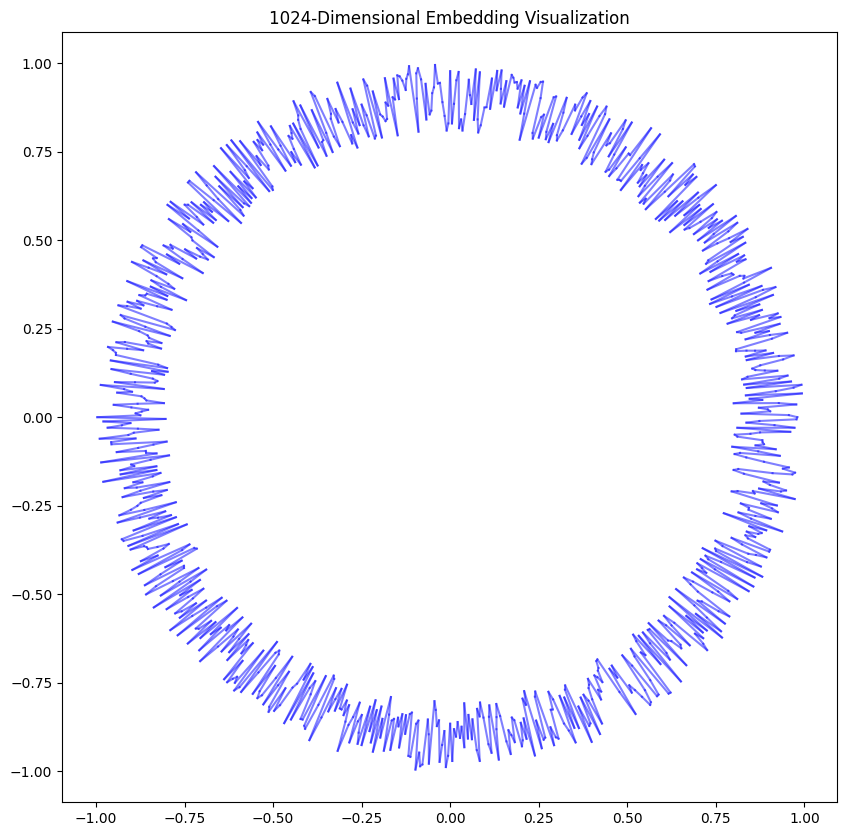

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_embedding_polygon(embedding):
    # Number of dimensions
    n_dims = len(embedding)

    # Calculate angles for the polygon vertices
    angles = np.linspace(0, 2*np.pi, n_dims, endpoint=False)

    # Calculate x, y coordinates for each dimension
    # The length from center = absolute value of the embedding dimension
    x = np.abs(embedding) * np.cos(angles)
    y = np.abs(embedding) * np.sin(angles)

    # Create figure
    plt.figure(figsize=(10, 10))

    # Connect adjacent points to form the polygon
    for i in range(n_dims):
        # Connect with next point (wrapping around at the end)
        next_i = (i + 1) % n_dims
        plt.plot([x[i], x[next_i]], [y[i], y[next_i]], 'b', alpha=0.5)

    plt.axis('equal')
    plt.title(f'{n_dims}-Dimensional Embedding Visualization')

    return plt

# Example usage
if __name__ == "__main__":
    # Generate sample embedding
    sample_embedding = np.random.uniform(0.8, 1, 1024)

    # Create visualization
    plot = plot_embedding_polygon(sample_embedding)
    plot.show()